Only need to run this once

In [1]:
import sys
from pathlib import Path

root_path = Path().resolve().parent
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))
    
from libs.vision import setup_camera 

In [2]:
import numpy as np
import cv2
import glob
import os
import time


cam = cv2.VideoCapture(1, cv2.CAP_DSHOW) #Specify DirectShow for faster connection

setup_camera(cam, (1920,1080), 30)

if not cam.isOpened(): 
    print("Camera could not be opened") 
    cam.release()
    exit()

#Create folder for the Calibration Images
folder_name = "Chessboard_Calib_imgs_1080"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

img_count=0
while img_count<20:
    ret, frame = cam.read()
    if not ret:
        print("Frame could not be read for some reason")
        cam.release()
        exit()

    resized_frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
    cv2.imshow(f"Take image {img_count+1} by pressing s",resized_frame)
    time.sleep(0.25)
    if cv2.waitKey(1) & 0xFF == ord('s'):
        filepath = os.path.join(folder_name, f"Calib_img{img_count}.png")
        cv2.imwrite(filepath,frame)
        img_count+=1
        cv2.destroyAllWindows()
    

cv2.destroyAllWindows()
cam.release()


############################################################


#square size to be measured
square_size=24 #mm
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objp=objp*square_size
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob(r'Chessboard_Calib_imgs_1080\*.png')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        resized_img = cv2.resize(img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
        cv2.imshow("Chessboard Corners", resized_img)
        cv2.waitKey(350)

cv2.destroyAllWindows()

#Get calibration matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

if ret:
    np.save("camera_matrix_1080.npy", mtx)
    np.save("distortion_coefficients_1080.npy", dist)
else:
    print("Camera calibration failed.")

Resolution is: 1920x1080
FPS is: 30


Usage

In [11]:
import cv2
import os
import numpy as np
def correct_camera_distortion(img, alpha=1):
    try:
        mtx = np.load("camera_matrix_1080.npy")
        dist = np.load("distortion_coefficients_1080.npy")
    except FileNotFoundError:
        print("Calibration files not found.")
        exit()

    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), alpha, (w,h))
    
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image borders
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]

    return dst

img = cv2.imread(os.path.join("Chessboard_Calib_imgs_1080", "Calib_img0.png")) 
img_c = correct_camera_distortion(img, alpha=1)

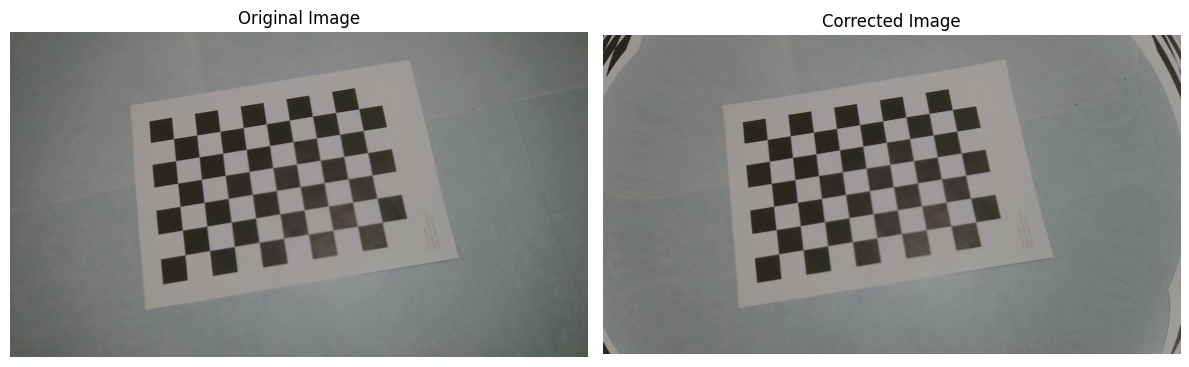

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(img_c)
axes[1].set_title("Corrected Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [13]:
img_c.shape

(811, 1466, 3)